# Setup
### let's download the Required Modules!

In [1]:
!pip install transformers torch datasets sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install --upgrade peft  # For LoRA support

# Connecting Colab with My drive

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
# Define the Drive path
drive_path = "/content/drive/MyDrive/FineTuning-LoRA"

In [3]:
from huggingface_hub import login
import os
from google.colab import userdata



hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

In [4]:
# Verify GPU availability
import torch

def check_gpu():
    if torch.cuda.is_available():
        print(f"GPU is available: {torch.cuda.get_device_name(0)}")
        print(f"CUDA version: {torch.version.cuda}")
    else:
        print("No GPU detected. Training will be slower on CPU.")
    return torch.cuda.is_available()

has_gpu = check_gpu()

GPU is available: Tesla T4
CUDA version: 12.4


In [5]:
import os

# Set random seed for reproducibility
torch.manual_seed(42)
if has_gpu:
    torch.cuda.manual_seed_all(42)

# Set environment variable to avoid tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("Setup complete. Ready to proceed with data preparation.")

Setup complete. Ready to proceed with data preparation.


# 2. Load and Prepare the Dataset


In [6]:
from datasets import load_dataset,Dataset

ds = load_dataset("ymoslem/CoVoST2-EN-AR-Text")['train']

README.md:   0%|          | 0.00/952 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/269380 [00:00<?, ? examples/s]

In [7]:
ds

Dataset({
    features: ['text_en', 'text_ar'],
    num_rows: 269380
})

In [8]:
ds[:2]

{'text_en': ['The breeding male is a duller version of the female.\n',
  'It has an ageing population.\n'],
 'text_ar': ['الذكر المُربي داكن أكثر من الإناث.\n',
  'متوسط أعمار السكان كبير.\n']}

In [9]:
def get_random_sample(dataset: Dataset, num_samples=150000, seed=42) -> Dataset:
    """Shuffle the dataset and select a random subset."""
    shuffled_dataset = dataset.shuffle(seed=seed)
    selected_dataset = shuffled_dataset.select(range(num_samples))
    return selected_dataset

In [10]:
shuffled_data = get_random_sample(ds)

In [11]:
shuffled_data

Dataset({
    features: ['text_en', 'text_ar'],
    num_rows: 150000
})

# Splitting the Dataset into (Training , Testing and Validation data)

In [12]:
split_ds = shuffled_data.train_test_split(test_size=0.2, seed=42)

train_ds = split_ds["train"]

temp_ds = split_ds["test"]



val_test_split = temp_ds.train_test_split(test_size=0.5, seed=42)

val_ds = val_test_split["train"]

test_ds = val_test_split["test"]



print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 120000, Validation size: 15000, Test size: 15000


# Cleaning

# Cleaning for english !

In [13]:
import re

def clean_english(text):
    # Remove newlines
    text = re.sub(r'\\n|\n', ' ', text)

    # Remove URLs or emails (optional based on your data)
    text = re.sub(r'http[s]?://\S+', '', text)

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove unnecessary punctuation but keep . , ! ? -
    text = re.sub(r'[^\w\s.,!?-]', '', text)

    text = text.lower()

    # Expand contractions
    contractions = {
        "don't": "do not", "isn't": "is not", "won't": "will not",
        "I'm": "I am", "you're": "you are", "he's": "he is", "she's": "she is" , "we're" : "we are" , "haven't" : "have not" , "hasn't" : "has not"
    }
    for contraction, full in contractions.items():
        text = text.replace(contraction, full)

    return text.strip().lower()

## Cleaning Arabic

In [14]:
def clean_arabic(text):
    # Remove newlines
    text = re.sub(r'\\n|\n', ' ', text)

    # Normalize 'أ', 'إ', 'آ' -> 'ا'
    text = re.sub(r'[أإآ]', 'ا', text)

    # Normalize 'ة' -> 'ه'
    text = re.sub(r'[ة]', 'ه', text)

    # Normalize Eastern Arabic numerals to Western Arabic numerals
    arabic_numerals = '٠١٢٣٤٥٦٧٨٩'
    western_numerals = '0123456789'
    trans = str.maketrans(arabic_numerals, western_numerals)
    text = text.translate(trans)

    # Remove diacritics (tashkeel)
    text = re.sub(r'[\u064B-\u065F]', '', text)

    # Remove tatweel
    text = re.sub(r'\u0640', '', text)

    # Remove Arabic and Western punctuation
    text = re.sub(r'[،؛«»,!?()\[\]{}"\'\\]', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

# Example usage
example_text = "أهلًا وسهلًا! كيف حالك؟"
cleaned_text = clean_arabic(example_text)
print(cleaned_text)


اهلا وسهلا كيف حالك؟


In [15]:
# Apply cleaning to the dataset using map
def clean_dataset(examples):
    return {
        "text_ar": [clean_arabic(text) for text in examples["text_ar"]],
        "text_en": [clean_english(text) for text in examples["text_en"]]
    }


train_ds = train_ds.map(clean_dataset, batched=True)
test_ds  = test_ds.map(clean_dataset, batched=True)
val_ds   = val_ds.map(clean_dataset, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [ ]:
test_ds[:2]

{'text_en': ['the skeptics society sponsors a lecture series at the california institute of technology.',
  'roman period spoons have been recovered from excavations in the city of london.'],
 'text_ar': ['ترعى جمعيه Skeptics سلسله من المحاضرات في معهد كاليفورنيا للتكنولوجيا.',
  'تم استرداد ملاعق الفتره الرومانيه من الحفريات في مدينه لندن.']}

# Loading the tokenizer

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

SRC_LANG = "ar_AR"  # src language: Arabic
TGT_LANG = "en_XX"  # Target language: English

tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
model     = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

## Checking the max sequence length in the data

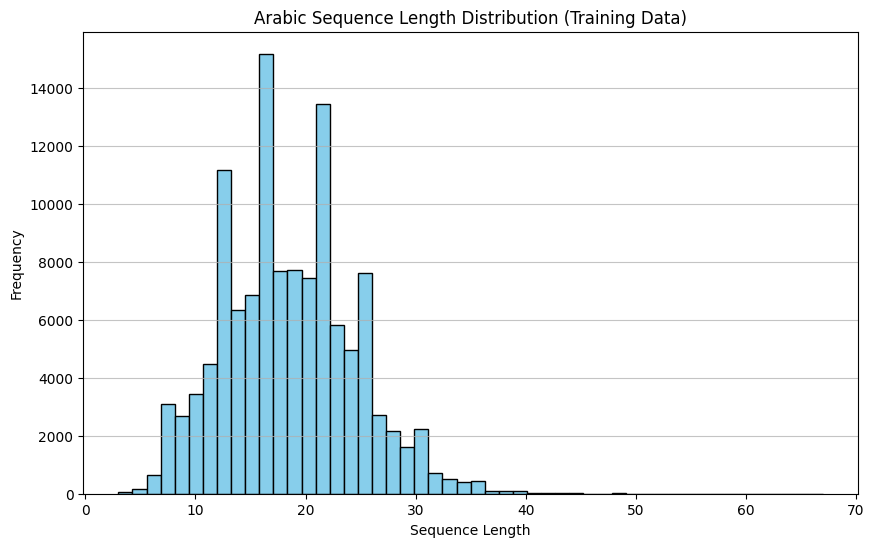

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


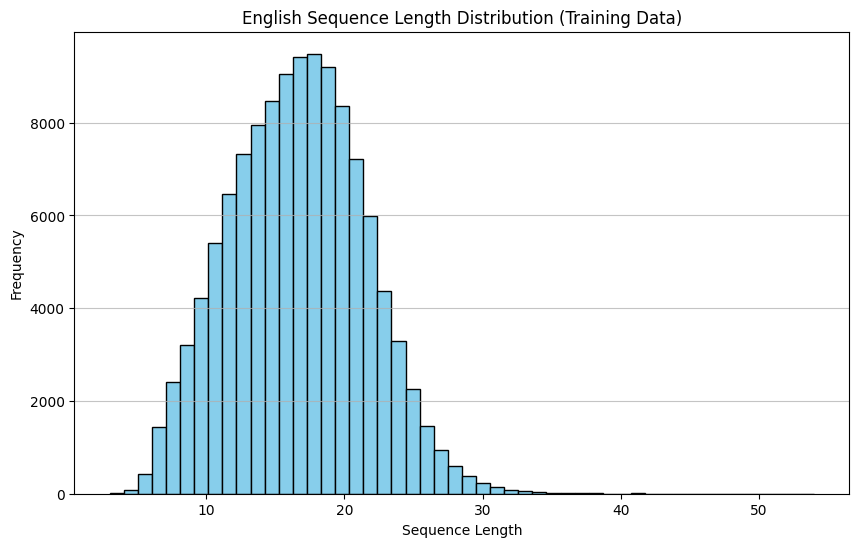

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sequence_length_distribution(dataset, language_key, tokenizer, title="Sequence Length Distribution"):
    """
    Calculates and plots the distribution of sequence lengths for a given language in a dataset.

    Args:
        dataset: A Hugging Face Dataset object.
        language_key (str): The key in the dataset examples corresponding to the text
                             for the desired language (e.g., 'text_ar').
        tokenizer: The tokenizer object used for the model.
        title (str, optional): The title of the plot. Defaults to "Sequence Length Distribution".
    """
    sequence_lengths = [len(tokenizer.encode(example[language_key])) for example in dataset]
    plt.figure(figsize=(10, 6))
    plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()


plot_sequence_length_distribution(train_ds, 'text_ar', tokenizer, title="Arabic Sequence Length Distribution (Training Data)")
plot_sequence_length_distribution(train_ds, 'text_en', tokenizer, title="English Sequence Length Distribution (Training Data)")

## Tokenizing the data

In [ ]:
def preprocess_function(examples):
    inputs = [ex for ex in examples['text_ar']]
    targets = [ex for ex in examples['text_en']]

    # Set source language(Arabic)
    tokenizer.src_lang = SRC_LANG

    # Set target language (English)
    tokenizer.tgt_lang = TGT_LANG

    # Process inputs
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    # Process targets using the text_target parameter
    model_inputs["labels"] = tokenizer(text_target=targets, max_length=128, truncation=True, padding="max_length")["input_ids"]

    return model_inputs

In [ ]:
train_ds = train_ds.map(preprocess_function, batched=True)

val_ds = val_ds.map(preprocess_function, batched=True)

test_ds = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

## LORA Config

In [ ]:
from peft import LoraConfig, get_peft_model

# Define LoRA Config
lora_config = LoraConfig(
    r=16,  # rank of adaptation
    lora_alpha=16,  # scaling factor
    target_modules=["q_proj", "v_proj",'k_proj'],  # typically target attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

In [ ]:
# Apply LoRA adapter
model_lora = get_peft_model(model, lora_config)

# Num of Param is going to be trained
model_lora.print_trainable_parameters()

trainable params: 3,538,944 || all params: 614,418,432 || trainable%: 0.5760


## Training Args

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=f"{drive_path}/checkpoints", # I added checkpoints incase I run out of time with GPU on kaggle !
    eval_strategy='epoch',
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    save_steps=500,
    save_strategy="steps",
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    logging_dir=f"{drive_path}/checkpoints",
    report_to="none",
)

# Set up the trainer: Configure the Seq2SeqTrainer

In [ ]:
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq

# Set up data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_lora)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Finally Training the model

In [ ]:
trainer.train(resume_from_checkpoint=f"{drive_path}/checkpoint-36500")

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
3,9.264600,9.268331
4,9.257000,9.267334
5,9.252700,9.267490


TrainOutput(global_step=75000, training_loss=4.752869095052083, metrics={'train_runtime': 12523.8319, 'train_samples_per_second': 47.909, 'train_steps_per_second': 5.989, 'total_flos': 1.641654779904e+17, 'train_loss': 4.752869095052083, 'epoch': 5.0})

In [ ]:
# Save the fine-tuned LoRA adapter
model_lora.save_pretrained(f"{drive_path}/model")
tokenizer.save_pretrained(f"{drive_path}/tokenizer")

('/content/drive/MyDrive/FineTuning-LoRA/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/FineTuning-LoRA/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/FineTuning-LoRA/tokenizer/sentencepiece.bpe.model',
 '/content/drive/MyDrive/FineTuning-LoRA/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/FineTuning-LoRA/tokenizer/tokenizer.json')

In [17]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel, PeftConfig

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("ZiadWaleed/mBart-LoRA-for-MT-ar-en2")

# Load PEFT config to get base model name
config = PeftConfig.from_pretrained("ZiadWaleed/mBart-LoRA-for-MT-ar-en2")
base_model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)

# Load LoRA adapter on top of base model
model = PeftModel.from_pretrained(base_model, "ZiadWaleed/mBart-LoRA-for-MT-ar-en2")


# Set model to evaluation mode
model.eval()

# Set up for translation
SRC_LANG = "ar_AR"
TGT_LANG = "en_XX"

tokenizer.src_lang = SRC_LANG
tokenizer.tgt_lang = TGT_LANG

# Set forced BOS token to the target language
model.config.forced_bos_token_id = tokenizer.lang_code_to_id[TGT_LANG]

tokenizer_config.json:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [35]:
def translate(arabic_text , model):

    device = torch.device("cpu")
    model = model.to(device)
    arabic_text = clean_arabic(arabic_text)
    inputs = tokenizer(arabic_text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to("cpu") for k, v in inputs.items()}  # Ensure on CPU

    model.eval()
    with torch.no_grad():
        translated_tokens = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=128,
            num_beams=5,
            early_stopping=True,
        )

    translated_text = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
    return translated_text


In [51]:
# Test with a sample
arabic_text = "كيف تتبرع للفقراء ؟ "
english_translation = translate(arabic_text , model)
print(f"Arabic: {arabic_text}")
print(f"English translation: {english_translation}")

Arabic: كيف تتبرع للفقراء ؟ 
English translation: how do you donate to the poor?


In [ ]:
!pip install evaluate

In [24]:
import evaluate
import numpy as np
import torch
from tqdm.auto import tqdm


def evaluate_translation_model(model, tokenizer, test_dataset, batch_size=8, max_samples=None):
    """
    Evaluate the translation model on a test dataset using BLEU, SacreBLEU, and chrF metrics.
    Args:
        model: The translation model to evaluate
        tokenizer: The tokenizer to use
        test_dataset: The test dataset containing 'text_ar' and 'text_en' fields
        batch_size: Batch size for evaluation
        max_samples: Maximum number of samples to evaluate (None for all)
    Returns:
        Dictionary with evaluation metrics
    """
    # Load metrics
    bleu = evaluate.load("bleu")
    sacrebleu = evaluate.load("sacrebleu")
    chrf = evaluate.load("chrf")


    # Set device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Set source and target language
    tokenizer.src_lang = "ar_AR"
    tokenizer.tgt_lang = "en_XX"
    model.config.forced_bos_token_id = tokenizer.lang_code_to_id["en_XX"]

    # Limit dataset size if specified
    if max_samples is not None:
        test_dataset = test_dataset.select(range(min(max_samples, len(test_dataset))))

    # Results storage
    all_predictions = []
    all_references = []

    # Process batches
    for i in tqdm(range(0, len(test_dataset), batch_size)):
        batch = test_dataset[i:i+batch_size]
        arabic_texts = batch["text_ar"]
        english_references = batch["text_en"]

        # Tokenize and move to GPU
        inputs = tokenizer(arabic_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate translations
        with torch.no_grad():
            translated_tokens = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                num_beams=5,
                early_stopping=True,
            )

        # Decode translations
        translated_texts = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)

        # Store results
        all_predictions.extend(translated_texts)
        all_references.extend(english_references)

    # Format for SacreBLEU (expects list of lists)
    references_for_sacrebleu = [[ref] for ref in all_references]

    # Calculate metrics
    bleu_score = bleu.compute(predictions=all_predictions, references=all_references)
    sacrebleu_score = sacrebleu.compute(predictions=all_predictions, references=references_for_sacrebleu)
    chrf_score = chrf.compute(predictions=all_predictions, references=references_for_sacrebleu)

    # Calculate chrF++ (with word n-grams)
    chrf_plus_plus_score = chrf.compute(
        predictions=all_predictions,
        references=references_for_sacrebleu,
        word_order=2  # Enable word n-grams for chrF++
    )



    # Print some example translations
    print("\nExample Translations:")
    for i in range(min(5, len(all_predictions))):
        print(f"\nSource (Arabic): {test_dataset[i]['text_ar']}")
        print(f"Reference (English): {test_dataset[i]['text_en']}")
        print(f"Prediction (English): {all_predictions[i]}")

    return {
        "bleu": bleu_score["bleu"],
        "sacrebleu": sacrebleu_score["score"],
        "chrf": chrf_score["score"],
        "chrf++": chrf_plus_plus_score["score"],
        "predictions": all_predictions,
        "num_samples": len(all_predictions),
        "examples": {
            "sources": test_dataset[:5]["text_ar"],
            "references": test_dataset[:5]["text_en"]
        }
    }

In [59]:

results_lora = evaluate_translation_model(model, tokenizer, test_ds, max_samples=15000)
print(f"Quick BLEU Score (15K samples): {results_lora['bleu']:.2f}")
print(f"Quick SacreBLEU Score (15K samples): {results_lora['sacrebleu']:.2f}")
print(f"Quick chrF Score (15K samples): {results_lora['chrf']:.2f}")
print(f"Quick chrF++ Score (15K samples): {results_lora['chrf++']:.2f}")

  0%|          | 0/1875 [00:00<?, ?it/s]


Example Translations:

Source (Arabic): ترعى جمعيه Skeptics سلسله من المحاضرات في معهد كاليفورنيا للتكنولوجيا.
Reference (English): the skeptics society sponsors a lecture series at the california institute of technology.
Prediction (English): skeptics sponsors a series of lectures at the california institute of technology.

Source (Arabic): تم استرداد ملاعق الفتره الرومانيه من الحفريات في مدينه لندن.
Reference (English): roman period spoons have been recovered from excavations in the city of london.
Prediction (English): the remains of the roman period were recovered from the excavations in london.

Source (Arabic): ورغم ذلك يمكن تسويقه وبيعه في الولايات المتحده.
Reference (English): nevertheless, it can be marketed and sold in the united states.
Prediction (English): however, it can be traded and sold in the united states.

Source (Arabic): اشار الى ان السبب هو ضغوط السفر المبالغ فيه.
Reference (English): he cited the pressure of too much travel as his reason.
Prediction (English): 

In [ ]:
print("\nExample Translations:")
for i in range(min(5, len(results_lora['predictions']))):
    print(f"\nSource (Arabic): {results_lora['examples']['sources'][i]}")
    print(f"Reference (English): {results_lora['examples']['references'][i]}")
    print(f"Prediction (English): {results_lora['predictions'][i]}")

In [28]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# Load pretrained mBART50 model and tokenizer
model_name = "facebook/mbart-large-50-many-to-many-mmt"
base_model2 = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer2 = MBart50TokenizerFast.from_pretrained(model_name)

# Set source and target language
tokenizer2.src_lang = "ar_AR"
tokenizer2.tgt_lang = "en_XX"
base_model2.config.forced_bos_token_id = tokenizer2.lang_code_to_id["en_XX"]


In [60]:
results_base_model = evaluate_translation_model(base_model2, tokenizer2, test_ds, max_samples=15000)
print(f"Quick BLEU Score (15K samples): {results_base_model['bleu']:.2f}")
print(f"Quick SacreBLEU Score (15K samples): {results_base_model['sacrebleu']:.2f}")
print(f"Quick chrF Score (15K samples): {results_base_model['chrf']:.2f}")
print(f"Quick chrF++ Score (15K samples): {results_base_model['chrf++']:.2f}")

  0%|          | 0/1875 [00:00<?, ?it/s]


Example Translations:

Source (Arabic): ترعى جمعيه Skeptics سلسله من المحاضرات في معهد كاليفورنيا للتكنولوجيا.
Reference (English): the skeptics society sponsors a lecture series at the california institute of technology.
Prediction (English): His group, Skeptics, holds a series of lectures at the California Institute of Technology.

Source (Arabic): تم استرداد ملاعق الفتره الرومانيه من الحفريات في مدينه لندن.
Reference (English): roman period spoons have been recovered from excavations in the city of london.
Prediction (English): The Roman bath lamps were recovered from the excavations in London City.

Source (Arabic): ورغم ذلك يمكن تسويقه وبيعه في الولايات المتحده.
Reference (English): nevertheless, it can be marketed and sold in the united states.
Prediction (English): And yet it can be sold and traded in the United States.

Source (Arabic): اشار الى ان السبب هو ضغوط السفر المبالغ فيه.
Reference (English): he cited the pressure of too much travel as his reason.
Prediction (English)

# Save the current model and tokenizer on Hugging face

In [ ]:

model_lora.push_to_hub("ZiadWaleed/mBart-LoRA-for-MT-ar-en2")
tokenizer.push_to_hub("ZiadWaleed/mBart-LoRA-for-MT-ar-en2")

adapter_model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ZiadWaleed/mBart-LoRA-for-MT-ar-en2/commit/de98a7b8af2bff480e3b75bc7289325812195b83', commit_message='Upload tokenizer', commit_description='', oid='de98a7b8af2bff480e3b75bc7289325812195b83', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ZiadWaleed/mBart-LoRA-for-MT-ar-en2', endpoint='https://huggingface.co', repo_type='model', repo_id='ZiadWaleed/mBart-LoRA-for-MT-ar-en2'), pr_revision=None, pr_num=None)

# Saving the dataset on HF

In [ ]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    'train': train_ds,
    'validation': val_ds,
    'test': test_ds
})

# Push to Hugging Face Hub
dataset.push_to_hub("ZiadWaleed/ymoslem-CoVoST2-EN-AR-Text-cleaned")


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/120 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ZiadWaleed/ymoslem-CoVoST2-EN-AR-Text-cleaned/commit/bd29f54210a2d2b6ae6521ab0956e41254a78c02', commit_message='Upload dataset', commit_description='', oid='bd29f54210a2d2b6ae6521ab0956e41254a78c02', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ZiadWaleed/ymoslem-CoVoST2-EN-AR-Text-cleaned', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ZiadWaleed/ymoslem-CoVoST2-EN-AR-Text-cleaned'), pr_revision=None, pr_num=None)

## Training for 3 more epochs to try to imporve the model

## let's define a new training args

In [61]:
import pandas as pd

df = pd.DataFrame(test_ds)

df['LoRA_predictions'] = results_lora['predictions']
df['base_model_predictions'] = results_base_model['predictions']

In [63]:
display(df.head(10))

,text_en,text_ar,LoRA_predictions,base_model_predictions
0,the skeptics society sponsors a lecture series...,ترعى جمعيه Skeptics سلسله من المحاضرات في معهد...,skeptics sponsors a series of lectures at the ...,"His group, Skeptics, holds a series of lecture..."
1,roman period spoons have been recovered from e...,تم استرداد ملاعق الفتره الرومانيه من الحفريات ...,the remains of the roman period were recovered...,The Roman bath lamps were recovered from the e...
2,"nevertheless, it can be marketed and sold in t...",ورغم ذلك يمكن تسويقه وبيعه في الولايات المتحده.,"however, it can be traded and sold in the unit...",And yet it can be sold and traded in the Unite...
3,he cited the pressure of too much travel as hi...,اشار الى ان السبب هو ضغوط السفر المبالغ فيه.,he pointed out that the reason was the excessi...,He pointed out that it's because of the overwh...
4,the group supports increased taxes for pollute...,تدعم المجموعه فرض ضرائب متزايده على المتسببين ...,the group supports increased taxes on polluter...,The group supports increasing taxes on pollute...
5,"after that show ended, he taught a television ...",بعد انتهاء هذا العرض قام بتدريس دوره الانتاج ا...,"after this performance, he taught television p...","At the end of this presentation, he taught a t..."
6,none of the original cast was present.,لم يحضر اي من الممثلين الاصليين.,none of the original cast members attended.,None of the original actors showed up.
7,ramone introduced optical surround sound for m...,قدم رامون الصوت المحيطي البصري للافلام.,ramon provided the visual peripheral sound of ...,Ramon introduced the visual surround sound to ...
8,space invaders has been remade on numerous pla...,تم اعاده انتاج فيلم غزاه الفضاء على العديد من ...,space invasion was re-produced on multiple pla...,The space invasion film was re-released on man...
9,jared wallace was then replaced by josh appleb...,ثم تم استبدال جاريد والاس ب جوش ابليباش.,garrett walace was then replaced by josh appel...,And then Jarrett Wallace was replaced by Josh ...


In [72]:
df.to_csv("./Predictions")